<a id="top"></a>
[Go to the bottom](#bottom)
---

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from zipfile import ZipFile
import requests

from datetime import datetime

## Get dataset

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_PATH_SEATTLE = os.path.join(DATA_PATH, 'seattle.zip')
FILE_PATH_BOSTON = os.path.join(DATA_PATH, 'boston.zip')

In [3]:
def extract_df_from_airbnb_zipfile(PATH_ZIPFILE) :
    '''
        INPUT : file path to a zipfile to open
        OUTPUT : a dictionary that contains dataframes of files 
        extracted from the zip file
    '''

    zf = ZipFile(PATH_ZIPFILE) 
    dfs = {
        text_file.filename : pd.read_csv(zf.open(text_file.filename ))
        for text_file in zf.infolist() 
        if text_file.filename.endswith('.csv')
    }
    
    print('Printing a dictionary with filenames as keys')
    for filename in dfs.keys() :
        print(f'Filename (keys): {filename}')
    
    return dfs

In [4]:
dfs_sea = extract_df_from_airbnb_zipfile(FILE_PATH_SEATTLE)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [5]:
listings_sea = dfs_sea['listings.csv']
reviews_sea = dfs_sea['reviews.csv']
calendar_sea = dfs_sea['calendar.csv']

---
<a id="function"></a>
---
## Functions
Collect all functions to use in this notebook.

In [6]:
# Helper function
def convert_str_to_datetime(df, date_feature) :

    date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
    
    return df[date_feature].apply(date_conversion)
    

def break_date(df, date_feature) :

    df_new = df.copy()
    
    df_new[date_feature] = convert_str_to_datetime(df_new, date_feature)

    df_new['year'] = df_new[date_feature].apply(lambda x : x.year)
    df_new['month'] = df_new[date_feature].apply(lambda x : x.month)
    df_new['day'] = df_new[date_feature].apply(lambda x : x.day)
    
    return df_new
    

In [7]:
def convert_price_float(series) :

    # Remove $ & , sign from price
    rep = {'$':'', ',': ''}

    for old, new in rep.items() :
        series = series.str.replace(old, new)
        
    # convert date type to float
    series = series.astype(float)
    
    return series

In [8]:
def convert_binary_num(series) :
    
    series = series.map({
        't': 1, 'f':0
    })
    
    return series

In [9]:
def plot_line_chart(x, height, layout_obj=False, rotation=False) :

    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.plot(x, height, marker='o')

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    plt.axhline(height.mean(), c='orange', ls='--')
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [10]:
def plot_bar_chart(x, height, layout_obj=False, rotation=False) :

    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.bar(x, height)

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [11]:
def map_calendar_month(series) :
    
    try : 
        series = series.map({
            1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
            7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
        })
        
        return series
        
    except :
        print('Failed mapping')
        return

[Go to the bottom](#bottom)

---
## Data exploration
The respective Airbnb datasets are downloaded from : 

- Seattle : https://www.kaggle.com/airbnb/seattle
- Boston  : https://www.kaggle.com/airbnb/boston



### Content
- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

Reference to the real use of the data: http://insideairbnb.com/seattle/

## `1.` Occupancy rate & price through the year
Working with **`calendar`** dataframe for both Seattle and Boston airbnb dataset. I will work on Seattle data first and subsequently apply a function for wrangling and visualizing Boston data.

### Data cleaning & exploration

In [12]:
# Copy a dataframe for data cleaning
calendar = calendar_sea.copy() 

In [13]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [14]:
# Data for 365 days from 2016-01-04 - 2017-01-02
len(calendar.date.value_counts().index) 

365

In [15]:
# Convert t, f to binary int : available
calendar.available = convert_binary_num(calendar.available)

In [16]:
# Remove $ & , sign from price
calendar.price = convert_price_float(calendar.price)

In [19]:
# Occpancy rate and price per day 
occ_price_tbl = calendar.groupby('date').mean().drop(columns='listing_id')
occ_price_tbl.columns = ['occ_rate', 'avg_rate']
occ_price_tbl.describe()

,occ_rate,avg_rate
count,365.000000,365.000000
mean,0.670610,137.901783
std,0.047899,9.860142
min,0.454426,117.685413
25%,0.647197,132.446443
50%,0.674961,136.731206
75%,0.702462,146.930502
max,0.765322,157.480000


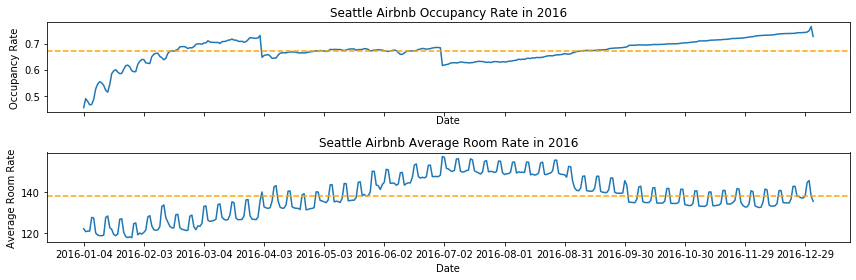

In [21]:
ticks = np.arange(0, len(occ_price_tbl.index)+1, 30)
labels = [occ_price_tbl.index[idx] for idx in ticks]

date = occ_price_tbl.index
rate_dict = [{'data': occ_price_tbl.occ_rate, 'desc': 'Occupancy Rate'},
             {'data': occ_price_tbl.avg_rate, 'desc': 'Average Room Rate'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'])
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].set_xticks(labels) 
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)
    
    fig.tight_layout()

plt.show()

The plots show the overall trend but not clearly in details. Let's break down the date into year, month and day

### Converting date from string to datetime object

In [22]:
# Convert into datetime object : date
date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
calendar.date = calendar.date.apply(date_conversion)

In [23]:
calendar.insert(2, 'year', calendar.date.apply(lambda x : x.year))
calendar.insert(3, 'month', calendar.date.apply(lambda x : x.month))
calendar.insert(4, 'day', calendar.date.apply(lambda x : x.day))

The above codes take too much time, which will be improved for any later use.

### Occupancy rate and average room rate in 2016
Monthly, Airbnb Seattle

In [24]:
analysis_seattle = calendar.groupby('month').mean()[['available', 'price']]
analysis_seattle.head()

,available,price
month,,
1,0.566937,122.912176
2,0.662208,124.293927
3,0.709187,128.644488
4,0.663847,135.097005
5,0.675670,139.538183


In [25]:
# Mapping integers to month name
analysis_seattle.index = map_calendar_month(analysis_seattle.index)

# Change column names
analysis_seattle.columns = ['occ_rate', 'room_rate']

# Confirm the change
analysis_seattle.head()

,occ_rate,room_rate
month,,
Jan,0.566937,122.912176
Feb,0.662208,124.293927
Mar,0.709187,128.644488
Apr,0.663847,135.097005
May,0.675670,139.538183


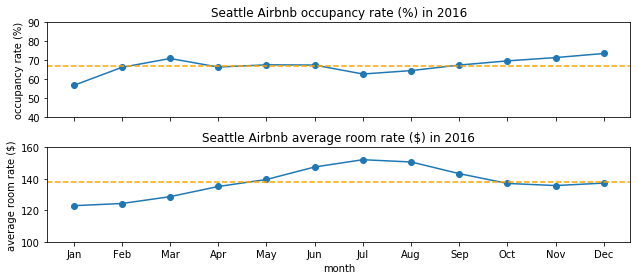

In [26]:
date = analysis_seattle.index
rate_dict = [{'data': analysis_seattle.occ_rate, 'desc': 'occupancy rate (%)'},
             {'data': analysis_seattle.room_rate, 'desc': 'average room rate ($)'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o')
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)


axes[1].set_xlabel('month')    
fig.tight_layout()

axes[0].set_yticks(np.arange(0.4, 0.8 + 0.2, 0.1))
axes[0].set_yticklabels([str(occ) for occ in range(40, 80 + 20, 10)])

axes[1].set_yticks(np.arange(100, 160 + 20, 20))
axes[1].set_yticklabels([str(price) for price in range(100, 160 + 20, 20)])

plt.show()

### How about RevPar ? 

RevPAR, or revenue per available room, is a performance metric in the hotel industry that is calculated by dividing a hotel's total guestroom revenue by the room count and the number of days in the period being measured. https://en.wikipedia.org/wiki/RevPAR

It can alternatively be calculated as occupancy rate $(# room occupied / # available) x average room rate$.

In [27]:
analysis_seattle['rev_par'] = ( analysis_seattle.occ_rate 
                                * analysis_seattle.room_rate )

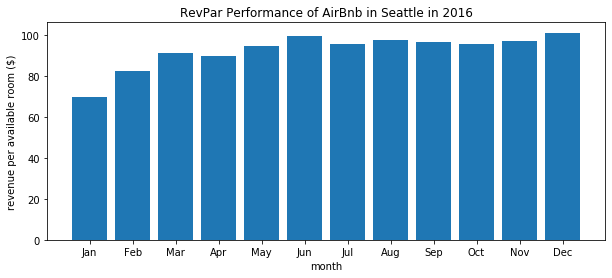

In [28]:
date = analysis_seattle.index
revpar = analysis_seattle['rev_par']
layout_obj = {
    'title': 'RevPar Performance of AirBnb in Seattle in 2016',
    'xlabel': 'month',
    'ylabel': 'revenue per available room ($)'
}

plot_bar_chart(date, revpar, layout_obj, rotation=False)

plt.show()

---
### Create a function for wrangling

In [29]:
def wrangle_airbnb_calendar_data(df) :
    
    # check if df has airbnb 'calendar' data
    if (df.shape[1] != 4 or df.columns.values[0] != 'listing_id') :
        print('Check if input dataframe is correct or data format has been changed')
        return 
    
    calendar = df.copy() 
    calendar.available = convert_binary_num(calendar.available)    
    calendar.price = convert_price_float(calendar.price)
    
    calendar_new = break_date(calendar, 'date')

    monthly_analysis = calendar_new.groupby('month').mean()[['available', 'price']]
    monthly_analysis.index = map_calendar_month(monthly_analysis.index)
    monthly_analysis.columns = ['occ_rate', 'room_rate']
    
    monthly_analysis['rev_par'] = ( monthly_analysis.occ_rate 
                                   * monthly_analysis.room_rate )
    
    return monthly_analysis
    

### Get Boston data & wrangle it

In [30]:
# Extract airbnb Boston 'calendar' data
df_bos = extract_df_from_airbnb_zipfile(FILE_PATH_BOSTON)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [31]:
calendar_bos = df_bos['calendar.csv']
listings_bos = df_bos['listings.csv']
reviews_bos = df_bos['reviews.csv']

In [32]:
analysis_boston = wrangle_airbnb_calendar_data(calendar_bos)

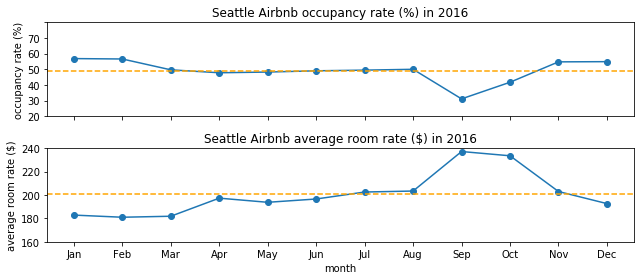

In [33]:
date = analysis_boston.index
rate_dict = [{'data': analysis_boston.occ_rate, 'desc': 'occupancy rate (%)'},
             {'data': analysis_boston.room_rate, 'desc': 'average room rate ($)'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o')
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)


axes[1].set_xlabel('month')    
fig.tight_layout()

axes[0].set_yticks(np.arange(0.2, 0.6 + 0.2, 0.1))
axes[0].set_yticklabels([str(occ) for occ in range(20, 60 + 20, 10)])

axes[1].set_yticks(np.arange(160, 240 + 20, 20))
axes[1].set_yticklabels([str(price) for price in range(160, 240 + 20, 20)])

plt.show()

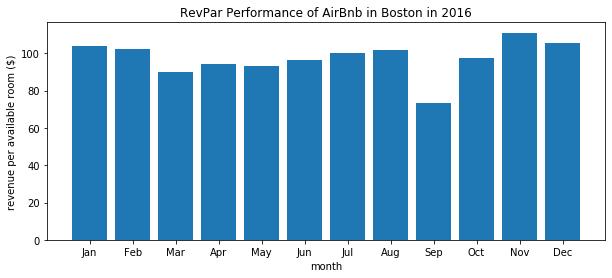

In [34]:
date = analysis_boston.index
revpar = analysis_boston['rev_par']
layout_obj = {
    'title': 'RevPar Performance of AirBnb in Boston in 2016',
    'xlabel': 'month',
    'ylabel': 'revenue per available room ($)'
}

plot_bar_chart(date, revpar, layout_obj, rotation=False)

plt.show()

### Comparison of revpar between Seattle and Boston

In [47]:
revpar_analysis_airbnb = pd.DataFrame({
    'revpar_seattle' : analysis_seattle.rev_par,
    'revpar_boston'  : analysis_boston.rev_par
}, index=analysis_seattle.index)

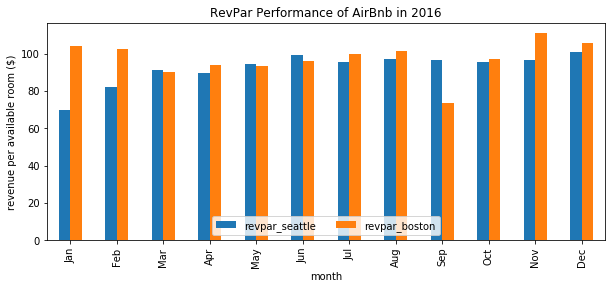

In [55]:
revpar_analysis_airbnb.plot.bar(figsize=(10,4))

plt.title('RevPar Performance of AirBnb in 2016')
plt.xlabel('month')
plt.ylabel('revenue per available room ($)')
plt.legend(loc='lower center', ncol=6)

plt.show()

---
## `2`. Trend in listing
Now to discover the supply side 

- \# of new hostings : `host_since`
- \# of hostings(at point in time) : `calculated_host_listings_count`
- growth of super_host : `host_is_superhost`
- hosting type: [`property_type`, `room_type`, `price`, ...]

In [98]:
# Copy a dataframe for data cleaning
listings = listings_sea.copy() 
listings.shape

(3818, 92)

In [99]:
cols_host = listings.loc[:, listings.columns.str.contains('host')]
extra_info = listings[['property_type', 'room_type', 'price']]

host_original = cols_host.join(extra_info)
print(host_original.shape)
host_original.head()

(3818, 22)


,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
0,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,2,Apartment,Entire home/apt,$85.00
1,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,6,Apartment,Entire home/apt,$150.00
2,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,2,House,Entire home/apt,$975.00
3,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,f,...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,1,Apartment,Entire home/apt,$100.00
4,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,1,House,Entire home/apt,$450.00


### Data cleaning

#### Drop unnessary / repetitive features
return host_clean_v0 dataframe

In [100]:
# drop unnecessary cols
# calculated_host_listings_count are more accurate info
drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
             'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
host_clean_v0 = host_original.drop(columns = drop_cols).copy()

In [101]:
#pd.options.display.max_row = None
#host[host.duplicated(subset=['host_id'], keep=False)].sort_values(by='host_id')

#### Drop duplicates

It looks that host_id is duplicated when a host has more than 1 hosting. Drop duplicates by host_id (not host_name!). 72% remain after removing duplicated rows, but it is rational to drop, and keep the last row (latest).

return host_clean_v1 dataframe

In [102]:
( host_clean_v0.drop_duplicates(subset=['host_id'], keep='last').shape[0] 
 / host_clean_v0.shape[0] )

0.7205343111576742

- There are rows with no information, which is to be removed. 
- `host_since` feature needs conversion to date time object. 

In [103]:
# Drop duplicates
host_clean_v1 = host_clean_v0.drop_duplicates(subset=['host_id'], keep='last')

#### Drop missing values

return host_clean_v2 dataframe

In [104]:
# Drop 2 missing values
host_clean_v1[host_clean_v1['host_since'].isnull()]

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
1297,42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$99.00
1419,1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$250.00


In [105]:
host_clean_v2 = host_clean_v1[host_clean_v1['host_since'].notnull()]

#### Change to relevant data type
return host_clean_v3 dataframe

In [106]:
# Convert into date time object
print(host_clean_v2.shape)
host_clean_v3 = break_date(host_clean_v2, 'host_since')

(2749, 15)


In [107]:
print(host_clean_v3.shape) 
#host_clean_v3.info()
#host_clean_v3.head()

(2749, 18)


In [108]:
host = host_clean_v3

---
### Create a function for wrangling
Checked if seattle and boston dataframe share all features in common : there are three features that Seattle listings dataset do not have, which however are not relevant for this analysis.

In [219]:
#listings_bos.columns.isin(listings_sea.columns)
listings_bos.columns[12:15]

Index(['access', 'interaction', 'house_rules'], dtype='object')

In [240]:
def wrangle_airbnb_host_data(df) :
    
    # Check if input dataframe is 'listings' dataset
    # Three three key columns must be inside the dataframe
    key_cols= ['host_id', 'host_since', 'calculated_host_listings_count']
    
    if df.columns.isin(key_cols).sum() !=3 :
        print('Check if input dataframe is correct or data format has been changed')
        return 
    
    print(f'Original dataframe has {df.shape[0]} x {df.shape[1]} dataset')
    
    df_copy = df.copy()
    
    # Drop uncessary columns
    host_related  = df.loc[:, df.columns.str.contains('host')]
    extra_info = df[['property_type', 'room_type', 'price']]
    
    host = cols_host.join(extra_info)
    drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
                 'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
    host = host.drop(columns = drop_cols)
    
    # Drop duplicates
    host = host.drop_duplicates(subset=['host_id'], keep='last')
    
    # Drop null 
    host = host[host['host_since'].notnull()]
    
    # Convert into date time object
    host = break_date(host, 'host_since')
    
    
    print(f'After wrangling : returning {host.shape[0]} x {host.shape[1]} dataset')
    
    return host
    

In [242]:
host_seattle = wrangle_airbnb_host_data(listings_sea)
host_boston = wrangle_airbnb_host_data(listings_bos)

Original dataframe has 3818 x 92 dataset
After wrangling : returning 2749 x 18 dataset
Original dataframe has 3585 x 95 dataset
After wrangling : returning 2749 x 18 dataset


### How has number of hosing grown year on year?

In [109]:
analysis_new_hostings = host.groupby('year').count()['host_id']

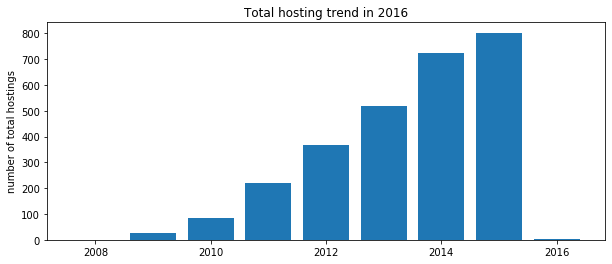

In [110]:
layout_obj = {
    'title': 'Total hosting trend in 2016',
    'xlabel': '',
    'ylabel': 'number of total hostings'
}

plot_bar_chart(analysis_new_hostings.index, analysis_new_hostings.values, layout_obj)

### How has the number of listings evolved by month in 2016?

In [111]:
group_total_listings = host.groupby('month').sum()['calculated_host_listings_count']

group_total_listings.index = map_calendar_month(group_total_hostings.index)

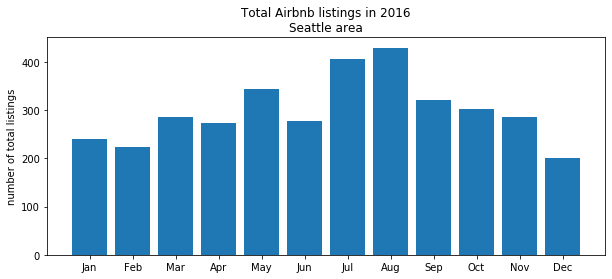

In [112]:
layout_obj = {
    'title': 'Total Airbnb listings in 2016\nSeattle area',
    'xlabel': '',
    'ylabel': 'number of total listings'
}

plot_bar_chart(group_total_hostings.index , group_total_hostings.values, layout_obj)

### How much percentage superhost accounts for?

In [114]:
# Convert into binary data
host.host_is_superhost = convert_binary_num(host.host_is_superhost)

In [195]:
group_superhost = host.groupby('month')['host_is_superhost'].mean()

In [117]:
group_superhost.index = map_calendar_month(group_superhost.index)

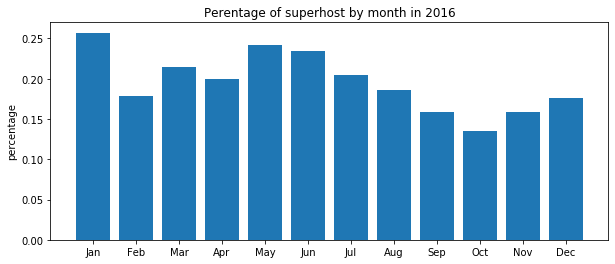

In [121]:
layout_obj = {
    'title'  : 'Perentage of superhost by month in 2016',
    'xlabel' : '',
    'tlabel' : 'percentage'
}

plot_bar_chart(group_superhost.index, group_superhost.values, layout_obj)

### General hosting statistics 

hosting type by `property_type`, `room_type`, `price`

In [122]:
property_type = host.property_type.value_counts()
room_type = host.room_type.value_counts()

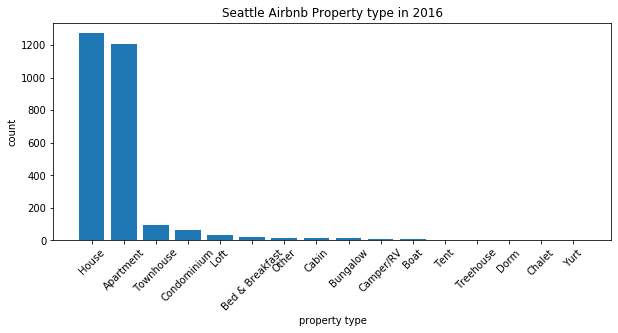

In [123]:
layout_obj = {
    'title' : 'Seattle Airbnb Property type in 2016',
    'xlabel': 'property type',
    'ylabel': 'count'
}

plot_bar_chart(property_type.index, property_type.values, layout_obj, rotation=True)

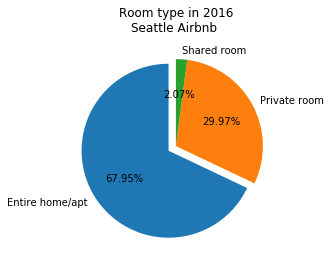

In [194]:
plt.pie(room_type.values, labels=room_type.index, startangle=90, 
        autopct='%1.2f%%', explode=(0.1, 0, 0))

plt.title('Room type in 2016\nSeattle Airbnb ')

plt.show()

count    2749.000000
mean      127.134958
std        88.209640
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64


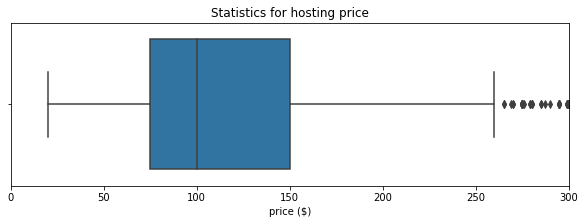

In [170]:
print(host.price.describe())

plt.figure(figsize=(10,3))
sns.boxplot(host.price)

plt.title('Statistics for hosting price')
plt.xlabel('price ($)')
plt.xlim((0,300))
plt.show()

### Not verified (extra)

In [176]:
host.host_identity_verified = convert_binary_num(host.host_identity_verified)

In [182]:
[verified_perc, 1-verified_perc]

[0.7519097853765006, 0.24809021462349945]

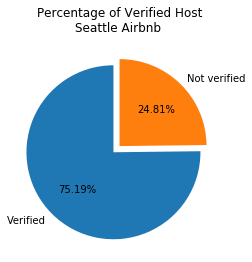

In [193]:
verified_perc = host.host_identity_verified.mean()

plt.pie([verified_perc, 1-verified_perc], labels=['Verified', 'Not verified'],
        startangle=90, autopct='%1.2f%%', explode=(0.1, 0))

plt.title('Percentage of Verified Host\nSeattle Airbnb ')

plt.show()

---
## `3.` By neighborhood

In [ ]:
cols_neighbor = [
    'id', 'neighborhood_overview', 'street', 'neighbourhood', 'neighbourhood_cleansed', 
    'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 
    'smart_location', 'country_code', 'country', 'latitude', 'longitude',
    'is_location_exact', 'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 
    'availability_30', 'availability_60', 'availability_90', 
    'availability_365'
]

In [ ]:
neighbor_original = listings_sea[cols_neighbor].copy()

### Data cleaning

In [ ]:
neighbor_clean_v0 = neighbor_original.copy()

In [ ]:
(neighbor_clean_v0.duplicated(subset=['id'], keep=False)).sum() # no duplicates

In [ ]:
neighbor_clean_v0.price = convert_price_float(neighbor_clean_v0.price)

In [ ]:
neighbor_clean_v0.neighbourhood_cleansed.value_counts()

In [ ]:
group_avg_by_neighbor = neighbor_clean_v0.groupby('neighbourhood_cleansed').mean()

In [ ]:
group_avg_by_neighbor.plot(kind='scatter', x='longitude', y='latitude', c='price',
                           colorbar=True, cmap='coolwarm')

plt.xticks(visible = True)
plt.show()

---
<a id="bottom"></a>
[Go to the top](#top)

<a id="function"></a>
[Go to functions](#function)